In [1]:
from train.training_session_v0 import load_training_session
import multiprocessing
import torch

device = "cuda"

session = load_training_session(
    save_path="saves/phase1/objective/Dec18_CLIP_MSE_384/epoch_20",
    studies={"gwilliams2023": "audio"},
    data_path="data",
)

dataloader = session.get_dataloader(buffer_size=1, num_workers=1, max_cache_size=100)

recording = session.recordings[2]

print(
    f"Showing recording: {recording.study_name}_{recording.subject_id}_{recording.task_id}"
)

dataloader.start_fetching(recordings=[recording])
batch = dataloader.get_recording()
brain, audio, recording = (
    batch.brain_segments["all"].to(device),
    batch.audio_segments.to(device),
    batch.recording,
)

conditions = {
    "study": f"{recording.study_name}",
    "subject": f"{recording.study_name}_{recording.subject_id}",
}
session.model.to(device)

with torch.no_grad():
    pred, _ = session.model(
        x=brain, recording=recording, conditions=conditions, train=False
    )

dataloader.stop()

Loading Gwilliams2023 with batch type audio
Data partitioned on studies ['gwilliams2023'].
Train: 135, Unseen Task: 12, Unseen Subject: 45, Unseen Both: 4.

SimpleConv initialized with 8448160 parameters, cond: ['study', 'subject']
Merger False, merger channels 0
ConvBlocks: 6, hidden_dim: 384, params 7973376


2024-12-19 20:26:07,050	INFO worker.py:1821 -- Started a local Ray instance.


Showing recording: Gwilliams2023_01_2


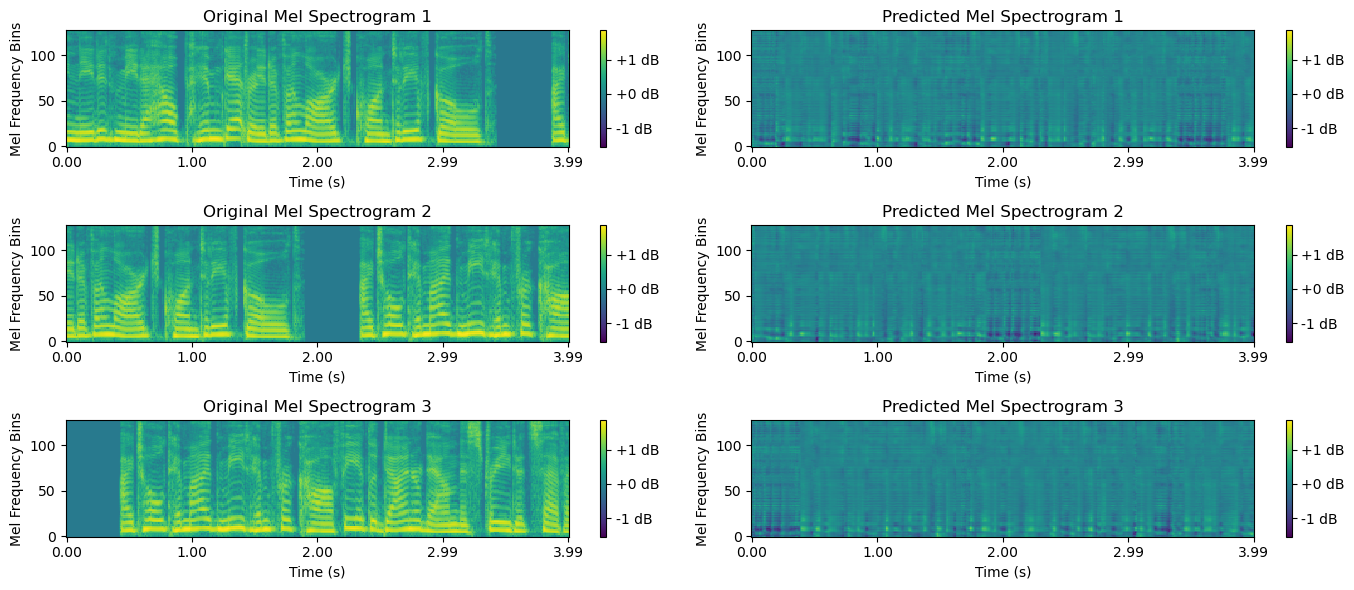

In [2]:
from utils.plot import mel_spectrogram

mel_spectrogram(x=audio[15:18].to("cpu"), max_plots=3, x_pred=pred[15:18].to("cpu"))

In [3]:
audio.max(), audio.min(), audio.mean(), pred.max(), pred.min(), pred.mean()

(tensor(1.9549, device='cuda:0'),
 tensor(-0.2430, device='cuda:0'),
 tensor(0.4793, device='cuda:0'),
 tensor(10.9885, device='cuda:0'),
 tensor(-5.4988, device='cuda:0'),
 tensor(0.0064, device='cuda:0'))

In [4]:
# from utils.plot import plot_training_metrics
# plot_training_metrics(session.metrics)